# COMTE 
Counterfactual Explanations for Machine Learning on Multivariate Time Series Data(COMTE) developed by Ates et al. [1] builds counterfactuals in multivariate setting by perturbing the features of a time series with the help of an heuristic algorithm.


[1] Emre Ates, Burak Aksar, Vitus J. Leung, and Ayse K. Coskun. Counterfactual Explanations for Machine Learning on Multivariate Time Series Data. 2021 International Conference on Applied Artificial Intelligence (ICAPAI), pages 1–8, May 2021. arXiv: 2008.10781. URL: http://arxiv.org/abs/2008.10781 (visited on 2022-03-25), doi:10.1109/ICAPAI49758.2021.9462056.

In [ ]:
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

## Load Data 
Load Data and reshape the data to fit a 1D-Conv ResNet. Note that the input for a 1D-Conv Resnet hat the shape (batch, features, timesteps).

In [2]:
dataset='BasicMotions'

In [3]:
X_train,y_train, X_test, y_test=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
train_y = y_train
test_y=y_test



In [4]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(train_y.reshape(-1,1))
pickle.dump(enc1,open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))



## Model Training / Loading
Trains a ResNet and saves the results.

In [5]:
n_pred_classes =train_y.shape[1]
print('n pred classes',n_pred_classes) 
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


n pred classes 4


In [6]:
model = ResNetBaseline(in_channels= X_train.shape[-1], num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)
#test_preds=np.argmax(test_preds,axis=1)
sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../../ClassificationModels/models/{dataset}/classification_report.csv', index = False)



Epoch: 1, Train loss: 1.057, Val loss: 1.181
Epoch: 2, Train loss: 1.138, Val loss: 1.007
Epoch: 3, Train loss: 0.937, Val loss: 0.869
Epoch: 4, Train loss: 0.836, Val loss: 0.759
Epoch: 5, Train loss: 0.741, Val loss: 0.644
Epoch: 6, Train loss: 0.58, Val loss: 0.441
Epoch: 7, Train loss: 0.321, Val loss: 0.249
Epoch: 8, Train loss: 0.149, Val loss: 0.115
Epoch: 9, Train loss: 0.065, Val loss: 0.032
Epoch: 10, Train loss: 0.035, Val loss: 0.032
Epoch: 11, Train loss: 0.002, Val loss: 0.005
Epoch: 12, Train loss: 0.1, Val loss: 0.006
Epoch: 13, Train loss: 0.114, Val loss: 0.506
Epoch: 14, Train loss: 0.231, Val loss: 0.029
Epoch: 15, Train loss: 0.029, Val loss: 1.138
Epoch: 16, Train loss: 0.443, Val loss: 0.02
Epoch: 17, Train loss: 0.001, Val loss: 0.025
Epoch: 18, Train loss: 0.011, Val loss: 0.229
Epoch: 19, Train loss: 0.161, Val loss: 0.16
Epoch: 20, Train loss: 0.024, Val loss: 0.053
Epoch: 21, Train loss: 0.001, Val loss: 0.388
Epoch: 22, Train loss: 0.004, Val loss: 0.441
Ep


## Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps:

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results

## 2. Initialization

COMTE works on all models returning a probability function. The Initialization takes the following arguments:

    `model`: The model to be explaines.
    `reference`: Tuple of Data and Labels.
    `backend`: `PYT`, `SK`, or `TF`.
    `mode`: second dimension is either `feat` or `time`. 
    `method`: Optimization Method either `brut` or `opt`.

In [7]:
item=test_x[1].reshape(1,test_x.shape[1],-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
y_pred = torch.nn.functional.softmax(model(_item)).detach().numpy()
y_label= np.argmax(y_pred)


/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [9]:
from TSInterpret.InterpretabilityModels.counterfactual.Ates import AtesCF
exp_model= AtesCF(model,(train_x,train_y),backend='PYT',mode='feat', method= 'opt')


2022-07-06 10:43:44.229770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 10:43:44.229786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



## 3. Call the explain method.

Prepeare the instance and the predicted label of the instance as parameters for the explain methods.

- item: item to be explained

In [10]:
exp = exp_model.explain(item)


Current may 2
3
Other ()
Best (1, 6, 100)


In [11]:
array, label=exp
print(label)

[3]


## 4. Visualization

All plot function take as input the item to be explained and the returned explanation. As as additonal option a figsize can be given. For visualizing saliency there are two visualization options provided:

    On Sample
    Heatmap



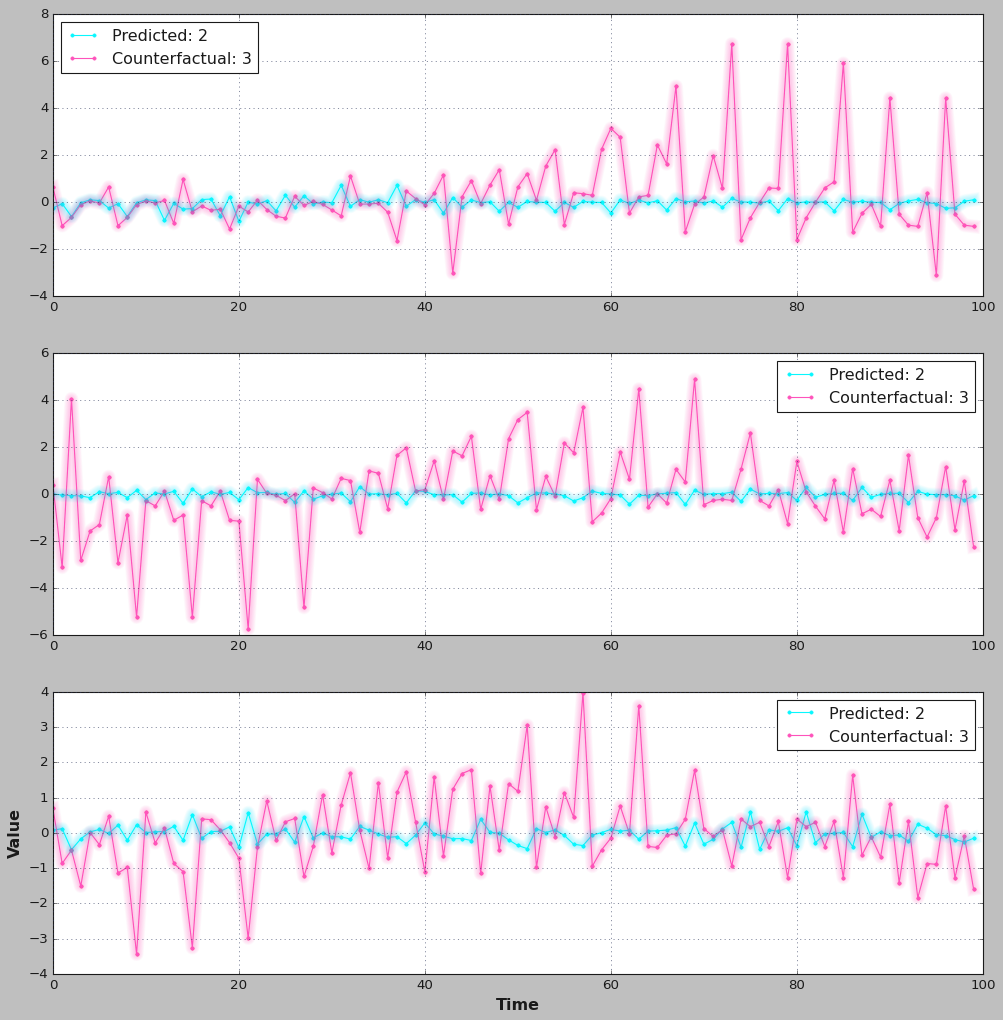

In [14]:
i=0
org_label=y_label
cf_label=label[0]
exp=array

exp_model.plot_in_one(item,org_label,exp,cf_label)